# Random Forest 

In [1]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_train_smote_12-06-2024.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_train_smote_12-06-2024.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_12-06-2024.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_test_12-06-2024.csv')

In [3]:
# Drop unnamed columns 
X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

In [4]:
print(list(X_train.columns))

['Condition', 'Sum_456', 'Sum_1', 'Sum_2', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum

In [5]:
columns_to_drop = ['Condition', 'Sum_456']

In [7]:
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [8]:
print(len(X_train.columns))
print(list(X_train.columns))

104
['Sum_1', 'Sum_2', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum_values', 'AU10_r__v

In [9]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

In [10]:
# Display each dataframe to verify the loading
print("X_train:")
display(X_train)

print("\nX_test:")
display(X_test)

X_train:


,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,12.000000,11.000000,0.919310,0.742910,0.847697,0.293698,0.830565,0.850749,0.485652,-0.019882,...,-0.408243,0.425279,-0.263230,-0.352093,0.970489,0.303553,0.447869,0.118497,1.010999,0.604244
1,11.000000,10.000000,-0.631136,-0.940957,-1.033638,0.293698,-1.333231,-1.131787,-0.198166,-0.410164,...,-0.807795,0.425279,-1.083828,-0.956263,0.265217,-0.581863,-0.586285,-0.436941,-0.690791,-0.627719
2,8.000000,8.000000,1.815800,0.489371,0.618471,0.293698,0.502919,0.589230,1.220328,-0.116460,...,-0.106153,0.338793,-0.903012,-0.467784,2.738438,0.349732,0.495312,0.760722,1.340506,0.733533
3,8.000000,8.000000,-1.082503,-0.947092,-1.043026,0.293698,-0.992134,-1.048249,-0.932584,-0.623317,...,-1.011057,-1.321739,-0.995226,-1.029314,-0.648617,-0.463357,-0.430560,-1.235383,-0.347166,-0.420355
4,8.000000,8.000000,-0.468956,0.765159,0.867251,0.293698,0.251033,0.703075,-0.188708,0.531833,...,-0.891051,-0.716337,-0.741624,-0.842706,-0.648377,0.115383,0.249103,0.864866,0.103879,0.211850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,10.591267,11.000000,0.404780,-0.213730,-0.122362,0.044925,0.080427,-0.068330,0.151535,-0.241475,...,0.300615,0.399711,0.416752,0.357324,0.224620,-0.040184,0.057747,0.705928,-0.190008,-0.008415
254,13.316483,9.316483,-0.387304,0.048483,0.186925,0.249664,-0.208703,0.074278,-0.191856,0.240390,...,0.653529,0.425279,0.613156,0.641681,-0.360287,-0.234234,-0.149341,-0.536546,-0.141645,-0.154002
255,9.826138,9.369604,0.278411,-0.036299,0.071646,0.293698,0.346129,0.150659,-0.257221,-0.271857,...,0.857897,0.385795,1.021472,0.949439,-0.080333,-0.052434,0.018721,0.638470,-0.105022,-0.017082
256,15.873762,14.781560,1.109901,0.315526,0.453389,-0.718435,0.009169,0.330545,0.530761,-0.447359,...,-1.563444,-0.007322,-1.529979,-1.582537,2.185380,0.938926,1.060632,0.864866,0.940212,1.043909



X_test:


,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,10.0,9.0,-0.394144,0.113788,0.253906,-0.241433,0.337966,0.277798,-0.874243,-0.569907,...,0.435610,0.096632,0.288670,0.368635,-0.626277,-0.010494,0.110803,-0.141865,0.104892,0.106922
1,14.0,12.0,0.825099,-0.190659,-0.069153,0.293698,-0.123168,-0.090616,0.406467,-0.315763,...,1.666168,0.425279,1.754932,1.737696,0.524330,-0.520376,-0.504625,0.864866,-0.575572,-0.536034
2,9.0,8.0,0.286661,0.569833,0.692545,-0.091596,0.683319,0.695538,-0.134549,0.036436,...,-0.001568,0.425279,0.076727,0.030450,-0.968274,-0.966036,-1.148606,-2.450403,-1.112739,-1.163339
3,17.0,19.0,2.340946,0.853918,0.944420,0.293698,1.052200,0.986488,1.731736,0.006584,...,2.000224,0.425279,1.243322,1.681337,1.646689,0.774393,0.910237,0.864866,0.405610,0.795791
4,10.0,9.0,-1.091775,-1.363165,-1.790147,-1.750502,-1.504745,-1.738265,-0.185078,-0.531768,...,0.880432,0.425279,0.570028,0.745445,0.147565,0.090425,0.222041,0.864866,-0.205765,0.114488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,10.0,12.0,0.586570,-0.251573,-0.137412,0.293698,0.077983,-0.080132,0.445783,-0.304901,...,1.589020,0.425279,1.907163,1.772730,0.511612,-0.405438,-0.356858,0.049067,-0.069567,-0.290302
80,9.0,8.0,1.352037,2.449155,2.157521,0.293698,2.139058,2.180886,1.291554,1.793664,...,-1.232566,-0.733634,-0.857109,-1.078772,-0.457404,-0.382910,-0.328588,-0.714660,-0.291292,-0.328794
81,10.0,10.0,-0.997972,-0.092138,0.038534,0.293698,-0.262103,-0.050299,-0.832871,-0.036330,...,-1.453697,-1.166064,-1.374354,-1.450532,-0.990030,-0.145579,-0.042962,0.864866,-0.062437,-0.053038
82,12.0,10.0,-0.331540,-0.829194,-0.868273,0.293698,-0.390558,-0.740947,0.849322,0.834394,...,-0.839698,-0.543365,-0.677054,-0.783841,-0.145438,-0.223852,-0.134841,-0.315439,-0.185071,-0.154475


# Optimized code 

Running the code below took 24 minutes. 

Test scores for each fold: [0.88372093 0.87209302 0.6744186 ]
Fold 1 score: 0.884, SD: 0.096
Fold 2 score: 0.872, SD: 0.096
Fold 3 score: 0.674, SD: 0.096
The mean score using nested cross-validation is: 0.810 ± 0.096
Fold 1 best parameters: {'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Fold 2 best parameters: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__n_estimators': 300}
Fold 3 best parameters: {'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__max_depth': None, 'classifier__n_estimators': 300}

Best model parameters: {'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__max_depth': None, 'classifier__n_estimators': 200}

Evaluating best model on test set

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        57
           1       0.68      0.70      0.69        27

    accuracy 

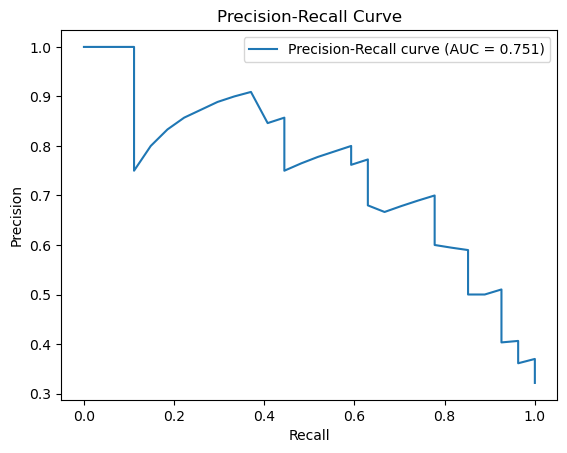

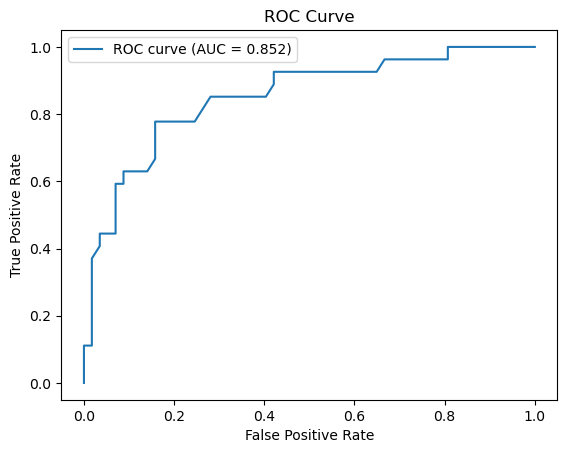

Using 258 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Test AUC-PR: 0.751

Number of selected features: 52
Selected feature names: ['Sum_1' 'Sum_2' 'AU01_r__sum_values' 'AU01_r__variance'
 'AU01_r__standard_deviation' 'AU01_r__maximum' 'AU01_r__mean'
 'AU01_r__root_mean_square' 'AU02_r__sum_values' 'AU02_r__variance'
 'AU02_r__standard_deviation' 'AU02_r__maximum' 'AU02_r__mean'
 'AU02_r__root_mean_square' 'AU04_r__sum_values' 'AU04_r__variance'
 'AU04_r__standard_deviation' 'AU04_r__maximum' 'AU04_r__mean'
 'AU04_r__root_mean_square' 'AU05_r__sum_values'
 'AU05_r__root_mean_square' 'AU06_r__sum_values' 'AU09_r__sum_values'
 'AU10_r__sum_values' 'AU12_r__root_mean_square' 'AU15_r__mean'
 'AU15_r__root_mean_square' 'AU17_r__sum_values' 'AU17_r__variance'
 'AU17_r__standard_deviation' 'AU17_r__maximum' 'AU17_r__mean'
 'AU17_r__root_mean_square' 'AU20_r__sum_values' 'AU20_r__variance'
 'AU20_r__standard_deviation' 'AU20_r__maximum' 'AU20_r__mean'
 'AU20_r__root_mean_square' 'AU23_r__sum_values' 'AU23_r__variance'
 'AU23_r__standard_deviation'

  0%|          | 0/84 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


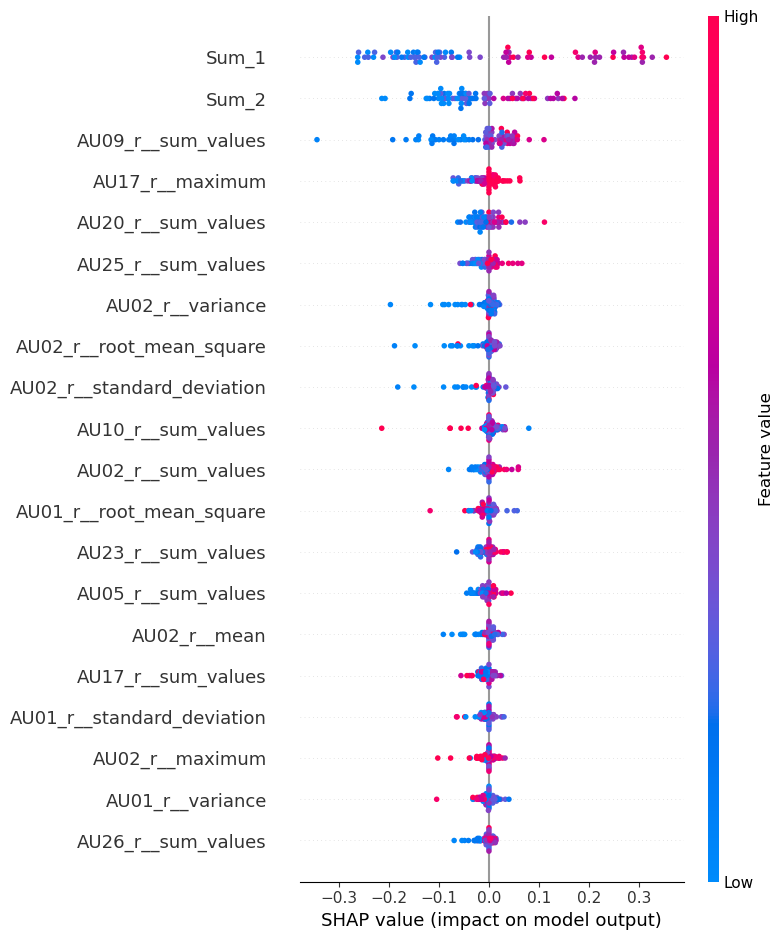

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import shap
import matplotlib.pyplot as plt

def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = RandomForestClassifier(random_state=0)  # Random forest classifier
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'classifier__class_weight': [{0: 0.75, 1: 1.48}, None],  # Class weights
        'classifier__max_depth': [None, 10, 20]  # Maximum depth of the tree
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")
    
    # Select the best model based on test scores
    best_fold_index = np.argmax(cv_results['test_score'])
    best_model = cv_results['estimator'][best_fold_index].best_estimator_
    best_params = cv_results['estimator'][best_fold_index].best_params_
    
    print(f"\nBest model parameters: {best_params}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    # Extract the names of the selected features
    feature_selector = best_model.named_steps['feature_selection']
    selected_features = np.array(X_test.columns)[feature_selector.support_]
    num_selected_features = len(selected_features)
    
    print(f"\nNumber of selected features: {num_selected_features}")
    print(f"Selected feature names: {selected_features}")
    
    return y_test_pred, best_model, selected_features

# Add SHAP analysis
def shap_analysis(best_model, X_train, X_test, feature_names):
    """Performs SHAP analysis on the best model."""
    # Transform the training and test data
    X_train_transformed = best_model.named_steps['feature_selection'].transform(X_train)
    X_test_transformed = best_model.named_steps['feature_selection'].transform(X_test)
    
    # Create SHAP explainer and calculate SHAP values
    explainer = shap.KernelExplainer(best_model.named_steps['classifier'].predict, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)

    # Summarize the effects of all the features
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, class_names=["Low VVR group", "High VVR group"])

# Example usage (assuming X_train, y_train, X_test, y_test are already defined):
feature_names = list(X_test.columns)
cv_results = perform_nested_cv(X_train, y_train)
y_test_pred, best_model, selected_features = evaluate_model(cv_results, X_test, y_test)
shap_analysis(best_model, X_train, X_test, selected_features)


# Confusion matrix 

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


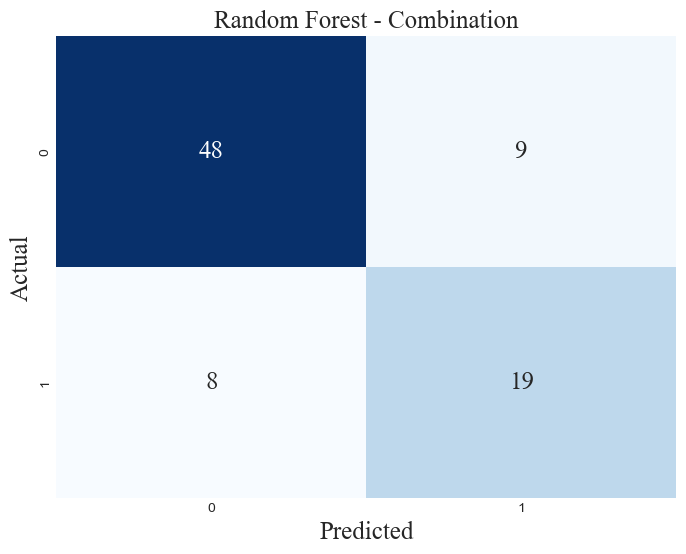

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Random Forest - Combination', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()